<h1><center> Manipulating Data to be Displayed and Analyzed as Rasters </center></h1>
<br/>
Note:  When downloading my datasets, I make a file system based off the dataset year which makes it easy to call them into the script. These files are downloaded as nc_file variable in the following script. The picture below shows the filing system I use. 
<br/> <br/>
The CreateRaster Function that is used in the last section of this script can be found in the MyFunctions.py script in the repository

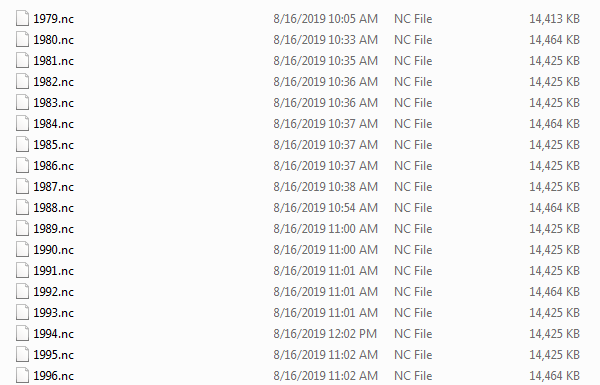

In [2]:
from PIL import Image
display(Image.open("C:/Users/vore/Desktop/HydroMet_Project/Code/FOR_GITHUB/File_system_for_ERA5.png"))

<h3> Packages </h3>

In [1]:
import numpy as np
import pandas as pd
from netCDF4 import Dataset,num2date
import rasterio
import fiona
from descartes import PolygonPatch
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.plot import show
import rasterio.mask

<h2> Converting daily precipitation estimations to monthly totals

In [3]:
var_Sum=pd.DataFrame({'Year':[],'Month':[],'Day':[],'var':[]})  # Initilize Dataframe for data collection
Year_range=np.arange(1979,2019,1)  # Years you want to loop through (My .nc files are named by year)

for Y in Year_range:
    nc_file= Dataset('C:/Users/vore/Desktop/HydroMet_Project/Data/ERA5/Hourly_precip/%s.nc'%Y)
    
#------------Time to DateTime Format--------------------------------------------------------
    # Change time to day--month--year: Find units and calandar the dataset uses
    t_units=nc_file.variables['time'].units
    t_cal=nc_file.variables['time'].calendar
    
    #convert each timestamp to datetime format for easier use
    t_datetime=[]
    for x in np.arange(0,len(nc_file.variables['time'])):
        t=(float(np.ma.getdata(nc_file.variables['time'][x]))) 
        t_datetime.append(num2date(t,units=t_units,calendar=t_cal))
    
    t_month=[];t_year=[];t_hour=[];t_day=[]
    for x in np.arange(0,len(t_datetime)):
        t_month.append(t_datetime[x].month)
        t_year.append(t_datetime[x].year)
        t_hour.append(t_datetime[x].hour)
        t_day.append(t_datetime[x].day)
    
    # Checks to make sure my files were named correctly (check year in file with the name of the file)
    # This will hault the script if any datafiles are misnamed. 
    if t_year[0]!=Y:
        print("YEAR ERROR: %s.nc is actually %s"%(Y, t_year[0]))
        break

    # Save Dates into a dataframe
    t=pd.DataFrame({'Year':t_year,'Month':t_month,'Day':t_day,'Hour':t_hour})

#----------------------------Convert to monthly sums-----------------------------------------------------------------

    for YEAR in np.arange(min(t_year),max(t_year)+1):
        index_year=np.where(t.Year==YEAR)[0]        # Finds the indicies where a given year of data occurs 
        
        for month in np.arange(1,13,1):             # Sums var values over monthly time spans 
            for day in np.arange(1,32,1):
                
                #change variable name as need be: 'tp' represents total varitation
                var_YEAR=nc_file.variables['tp'][min(index_year):max(index_year)+1,:,:] #extracts data in a given year
            
                # extracts data for a given month
                index_month=np.where(t.Month[min(index_year):max(index_year+1)]==month)[0]
                index_day=np.where(t.Day[min(index_year):max(index_year+1)]==day)[0]
                
                idx_use=np.intersect1d(index_month,index_day)
                
                if len(idx_use)<1:
                    continue
                    
                var=var_YEAR[min(idx_use):max(idx_use)+1]
                
            
                #sums precip values for the month and converts to mm
                p=np.sum(np.array(var*1000),axis=0)   
            
                #saves precipitation values
                var_Sum=var_Sum.append({'Year':YEAR,'Month':month,'Day':day,'var':p},ignore_index=True)
                
                
#----------------------------extract latitude and longitude data-----------------------------------------------                
lat=[]
for x in np.arange(0,len(nc_file.variables['latitude'])):
    lat.append(nc_file.variables['latitude'][x])

long=[]
for x in np.arange(0,len(nc_file.variables['longitude'])):
    long.append(nc_file.variables['longitude'][x])

                          


In [ ]:
for ix in np.arange(0,len(var_Sum)):
    x=var_Sum[var_Sum.index==ix].var
    
    Z_ERA5=[]
    for i in lat:
        for j in long:
            Z_ERA5.append([x[i][j],lat[i],long[j]])
            
    var_Sum['Raster']=Z_ERA5
    
#--------------------------- Save cooridnates and variable data-----------------------------------------------   
# save as a pickle file in order to keep the array data. If you save as a csv, for example, the rasters arrays will 
    #keep their shape.
    
# var_Sum.to_pickle('C:/Users/vore/Desktop/HydroMet_Project/Data/ERA5/var_daily_totals/var_Raster.pkl')

This produces arrays for each month that can easily be turned into rasters, with each row of the array containing the precipitation estimation, latitude and longitude.  <br/>
<br/>
__Note__:If your dataset is large and you only need small snippets of it (i.e. watershed, mountain range, etc.) I would suggest cutting out a more narrow range of latitude and longitude values to make the code run faster. 

<h2> Creating Rasters

In [ ]:
#User Defined inputs
working= var_Sum.Raster[0]
Resx= 0.28125
Resy= 0.28125
Save_file="C:/Users/vore/Desktop/HydroMet_Project/Data/ERA5/Working_Rasters/precip_Working_raster_ERA5.tif"

# reshape data dimensions
precip_array_ERA5=np.reshape(np.array(working)[:,0],(-1,len(long)))
lat_array_ERA5=np.reshape(np.array(working)[:,1], (-1,len(long)))
lon_array_ERA5=np.reshape(np.array(working)[:,2],(-1,len(long)))

#create raster using CreateRaster Function in MyFunction.py script
CreateRaster(lon=lon_array_ERA5,lat=lat_array_ERA5,data=precip_array_ERA5, resx=Resx, resy=Resy, save_directory=Save_ERA5)

#open raster and display
Temp_raster=rasterio.open(Save_file)
rasterio.plot.show(Temp_raster,1)
